#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce

#### In an effort to generalize for future EDA, 'df' makes it easier to debug

In [28]:
df = pd.read_csv('C:/Users/norri/Desktop/cortex_Push.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientId                                      54039 non-null  int64  
 1   Program Id                                    54039 non-null  int64  
 2   Program Name                                  54039 non-null  object 
 3   Retailers                                     54039 non-null  object 
 4   TacticId                                      54039 non-null  int64  
 5   Tactic                                        54039 non-null  object 
 6   CategoryId                                    54039 non-null  int64  
 7   Tactic Category                               54039 non-null  object 
 8   VendorId                                      53135 non-null  float64
 9   Vendor                                        54039 non-null 

### The info function above tells us we have three data types and counts of each. The next section will explore those variables in groups.

In [22]:
# df = df.drop([], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()

There are 9 categorical variables

The categorical variables are :

 ['Program Name', 'Retailers', 'Tactic', 'Tactic Category', 'Vendor', 'Tactic Start Date', 'Tactic End Date', 'Brand', 'RMN']
Program Name         0.0
Retailers            0.0
Tactic               0.0
Tactic Category      0.0
Vendor               0.0
Tactic Start Date    0.0
Tactic End Date      0.0
Brand                0.0
RMN                  0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Program Name       54039 non-null  object
 1   Retailers          54039 non-null  object
 2   Tactic             54039 non-null  object
 3   Tactic Category    54039 non-null  object
 4   Vendor             54039 non-null  object
 5   Tactic Start Date  54039 non-null  object
 6   Tactic End Date    54039 non-null  object
 7   Brand              54039 non-n

,Program Name,Retailers,Tactic,Tactic Category,Vendor,Tactic Start Date,Tactic End Date,Brand,RMN
count,54039,54039,54039,54039,54039,54039,54039,54039,54039
unique,537,45,170,20,105,446,431,97,2
top,FY20 Q2 Albertsons Monopoly,Kroger Co,Retailer-Led Tactics: 84.51 - LCM,Retailer-Led Tactics,84.51,2/6/2020,5/7/2020,Aidells,No
freq,2688,23378,10578,33912,18631,2688,2688,3412,42555


In [24]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 8 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'Weeks']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
Weeks                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      54039 non-null  int64
 1   Program Id                    54039 non-null  int64
 2   TacticId                      54039 non-null  int64
 3   CategoryId                    54039 non-null  int64
 4   Total Impressions for Tactic  54039 non-null  int64
 5   BrandId         

In [29]:
df = df.drop(
    ['Base $', 'Incr $', 'Base Units', 'Incr Units',
     '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
     'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 24 float variables

The float variables are :

 ['VendorId', 'Total Tactic Spend', 'Total Tactic Insertion Cost', 'Total Tactic Redemption Cost', 'StoreCount', 'Impressions per Week', 'Brand Share of Program Budget', 'Brand Share of Total Tactic Spend', 'Brand Share of Tactic Insertion Cost', 'Brand Share of Tactic Redemption Cost', 'Weekly Brand Share of Total Tactic Spend', 'Weekly Brand Share of Tactic Insertion Cost', 'Weekly Brand Share of Tactic Redemption Cost', 'Total Sales', 'Units', 'Avg Unit Price', 'Any Promo Units', '%ACV Distribution', 'Any Promo %ACV', 'Disp w/o Feat %ACV', 'Feat & Disp %ACV', 'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Number of UPCs Selling']
Total Sales               62.036677
Units                     62.036677
Avg Unit Price            62.021873
Any Promo Units           62.021873
%ACV Distribution         62.099595
Any Promo %ACV            62.099595
Disp w/o Feat %ACV        62.099595
Feat & Disp %ACV          62.099595
Feat w/o Disp 

In [30]:
# can drop year ago columns
df_fp = df.select_dtypes('float')
df_num = df_fp
df_fp.describe()

,VendorId,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,Brand Share of Tactic Insertion Cost,Brand Share of Tactic Redemption Cost,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,53135.000000,54039.000000,54039.000000,54039.000000,54031.000000,5.403900e+04,54039.000000,54039.000000,54039.000000,54039.000000,...,2.051500e+04,20523.000000,2.052300e+04,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20523.000000
mean,45.138270,33927.000842,27540.179030,6386.821813,1033.474764,3.044121e+06,0.239102,7075.707566,6081.785173,993.922393,...,1.984949e+05,5.651272,6.032207e+04,86.373085,45.409581,2.082658,0.820302,17.774523,36.872715,16.736686
std,53.527778,61813.987485,61974.946222,12328.696054,1304.144639,3.048686e+07,0.291679,14125.204066,13789.562246,3232.831264,...,4.354113e+05,2.231451,1.662932e+05,25.044837,33.745145,5.432150,3.497597,27.201852,31.021937,16.984060
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.331000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,8714.000000,4494.000000,0.000000,0.000000,7.064667e+03,0.056904,635.431163,321.889388,0.000000,...,2.088150e+04,4.000000,2.202813e+03,91.901000,12.753000,0.000000,0.000000,0.000000,7.571000,6.000000
50%,32.000000,20000.000000,10480.890000,0.000000,0.000000,3.739900e+04,0.123091,2291.429059,1200.018400,0.000000,...,7.331000e+04,5.149000,1.539920e+04,98.872000,43.668000,0.000000,0.000000,0.900000,30.984000,11.000000
75%,63.000000,40000.000000,29994.800000,9750.000000,2277.000000,5.371706e+05,0.271429,6725.352668,5000.000000,859.193251,...,1.814967e+05,7.119000,5.465139e+04,99.761000,74.771000,1.900000,0.000000,26.047000,61.200000,20.000000
max,256.000000,690000.000000,690000.000000,151705.000000,15000.000000,4.500000e+08,1.000000,187676.881500,187676.881500,95277.041730,...,3.600584e+06,14.957000,2.074647e+06,100.000000,100.000000,66.782000,58.213000,100.000000,100.000000,83.000000


### Clearly the float variables contain all the missing data in the dataset. In
### cases like this, dropping the missing values are a trade-off to consider
### against dropping an entire column and losing its input into the model

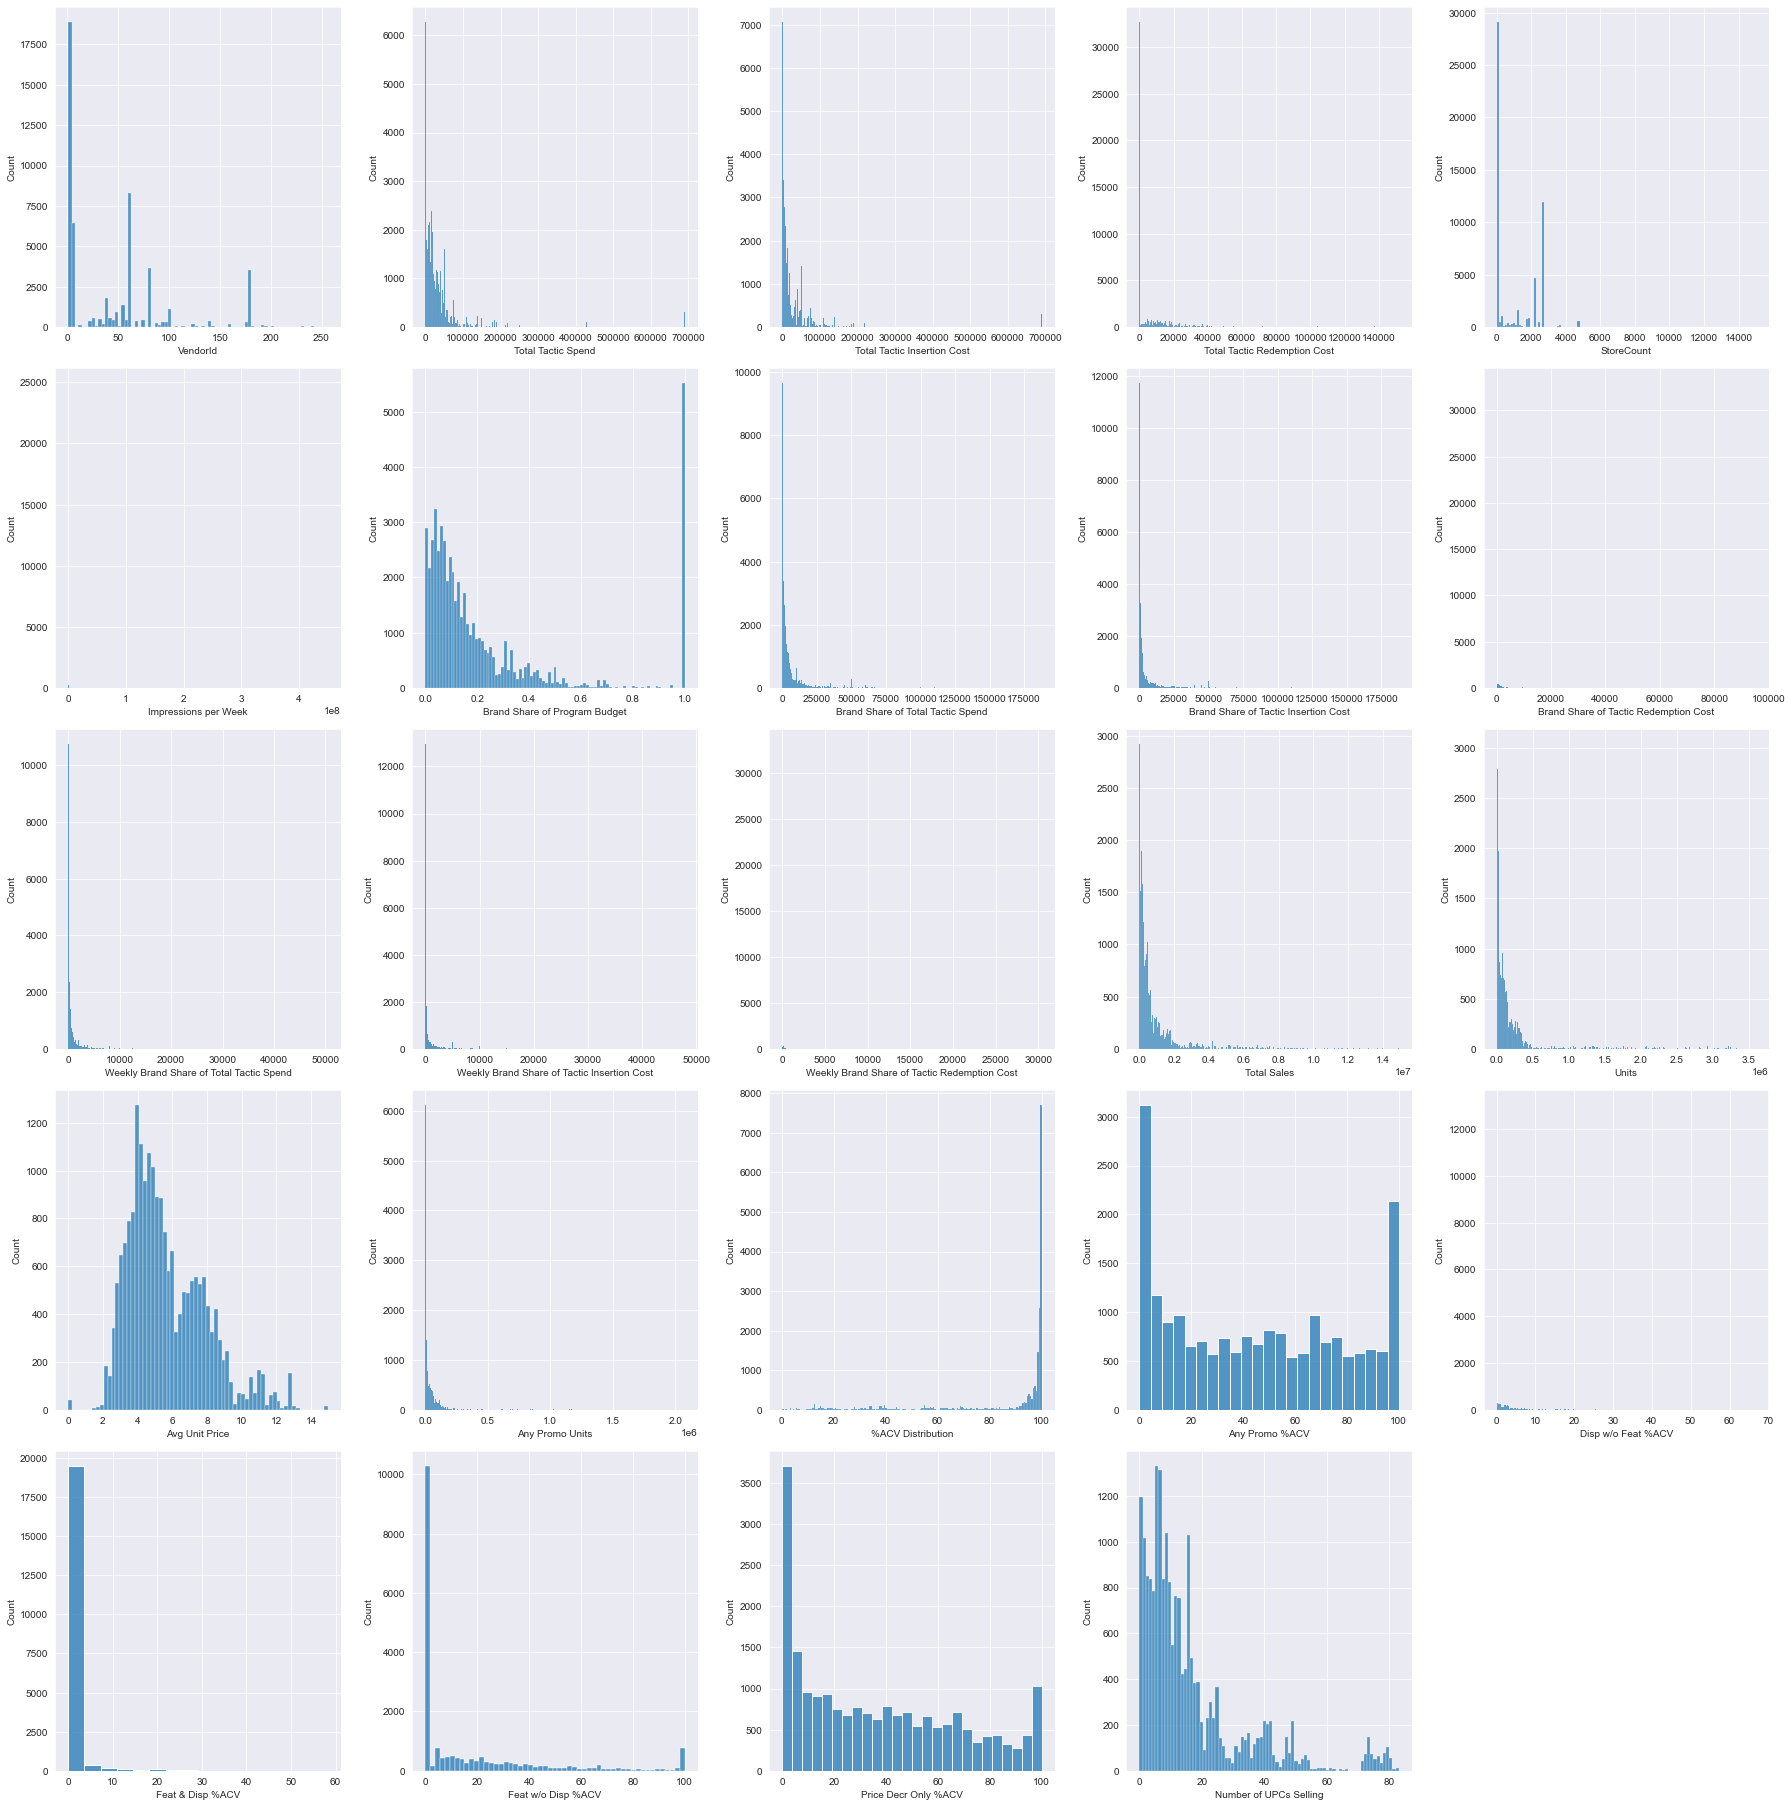

In [31]:
# this section should come later; for larger datasets takes too long to run
# with too little return in information
cols = 5
rows = 20
num_cols = df_num.select_dtypes(exclude='object').columns
fig = plt.figure(figsize=(cols * 5, rows * 5))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    sns.histplot(x=df[col], ax=ax)
fig.tight_layout()
plt.show()

In [39]:
# these visualizations provide some clue as to how to model the large number
# of variables and to examine their relationships
corr = df_num.corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

C:\Users\norri\AppData\Local\Temp\ipykernel_23904\1793195246.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap="coolwarm").set_precision(2)


,VendorId,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,Brand Share of Tactic Insertion Cost,Brand Share of Tactic Redemption Cost,Weekly Brand Share of Total Tactic Spend,Weekly Brand Share of Tactic Insertion Cost,Weekly Brand Share of Tactic Redemption Cost,Total Sales,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
VendorId,1.00,0.10,0.17,-0.36,0.04,-0.05,0.26,0.22,0.26,-0.15,0.22,0.26,-0.10,0.20,0.17,-0.02,0.05,-0.08,-0.15,-0.01,-0.09,-0.14,-0.13,-0.11
Total Tactic Spend,0.10,1.00,0.98,0.09,0.00,0.37,-0.06,0.48,0.48,0.06,0.31,0.31,0.05,0.17,0.17,-0.03,0.09,0.02,-0.04,0.01,-0.03,-0.04,-0.05,-0.01
Total Tactic Insertion Cost,0.17,0.98,1.00,-0.11,-0.02,0.38,-0.03,0.48,0.51,-0.06,0.31,0.34,-0.05,0.17,0.17,-0.02,0.09,0.01,-0.05,0.01,-0.03,-0.05,-0.05,-0.00
Total Tactic Redemption Cost,-0.36,0.09,-0.11,1.00,0.10,-0.05,-0.15,0.01,-0.14,0.64,-0.02,-0.15,0.52,-0.04,-0.03,-0.03,-0.00,0.04,0.05,-0.02,0.01,0.04,0.04,-0.02
StoreCount,0.04,0.00,-0.02,0.10,1.00,-0.01,-0.16,-0.04,-0.04,0.01,-0.04,-0.04,0.01,0.13,0.12,-0.05,0.12,0.03,0.02,0.14,0.02,-0.00,0.03,0.09
Impressions per Week,-0.05,0.37,0.38,-0.05,-0.01,1.00,-0.04,0.11,0.12,-0.03,0.06,0.07,-0.02,-0.02,-0.02,0.01,-0.01,0.03,0.03,0.02,0.03,0.02,0.02,0.03
Brand Share of Program Budget,0.26,-0.06,-0.03,-0.15,-0.16,-0.04,1.00,0.52,0.51,0.12,0.56,0.55,0.13,-0.09,-0.10,0.09,-0.08,-0.30,-0.18,0.00,-0.04,-0.11,-0.20,-0.30
Brand Share of Total Tactic Spend,0.22,0.48,0.48,0.01,-0.04,0.11,0.52,1.00,0.97,0.22,0.83,0.81,0.18,0.16,0.13,0.06,0.07,-0.09,-0.12,0.06,-0.03,-0.07,-0.16,-0.14
Brand Share of Tactic Insertion Cost,0.26,0.48,0.51,-0.14,-0.04,0.12,0.51,0.97,1.00,-0.01,0.81,0.84,-0.01,0.17,0.14,0.06,0.08,-0.09,-0.13,0.07,-0.03,-0.07,-0.16,-0.13
Brand Share of Tactic Redemption Cost,-0.15,0.06,-0.06,0.64,0.01,-0.03,0.12,0.22,-0.01,1.00,0.18,-0.02,0.84,-0.05,-0.04,-0.00,-0.02,0.00,0.03,-0.02,0.00,0.03,0.01,-0.04


##### Imputation of missing values is too unreliable to base the rest of the
##### model on. Later tests will tell if there is any bias present. This is when
##### the most standout variables should be chosen for the model

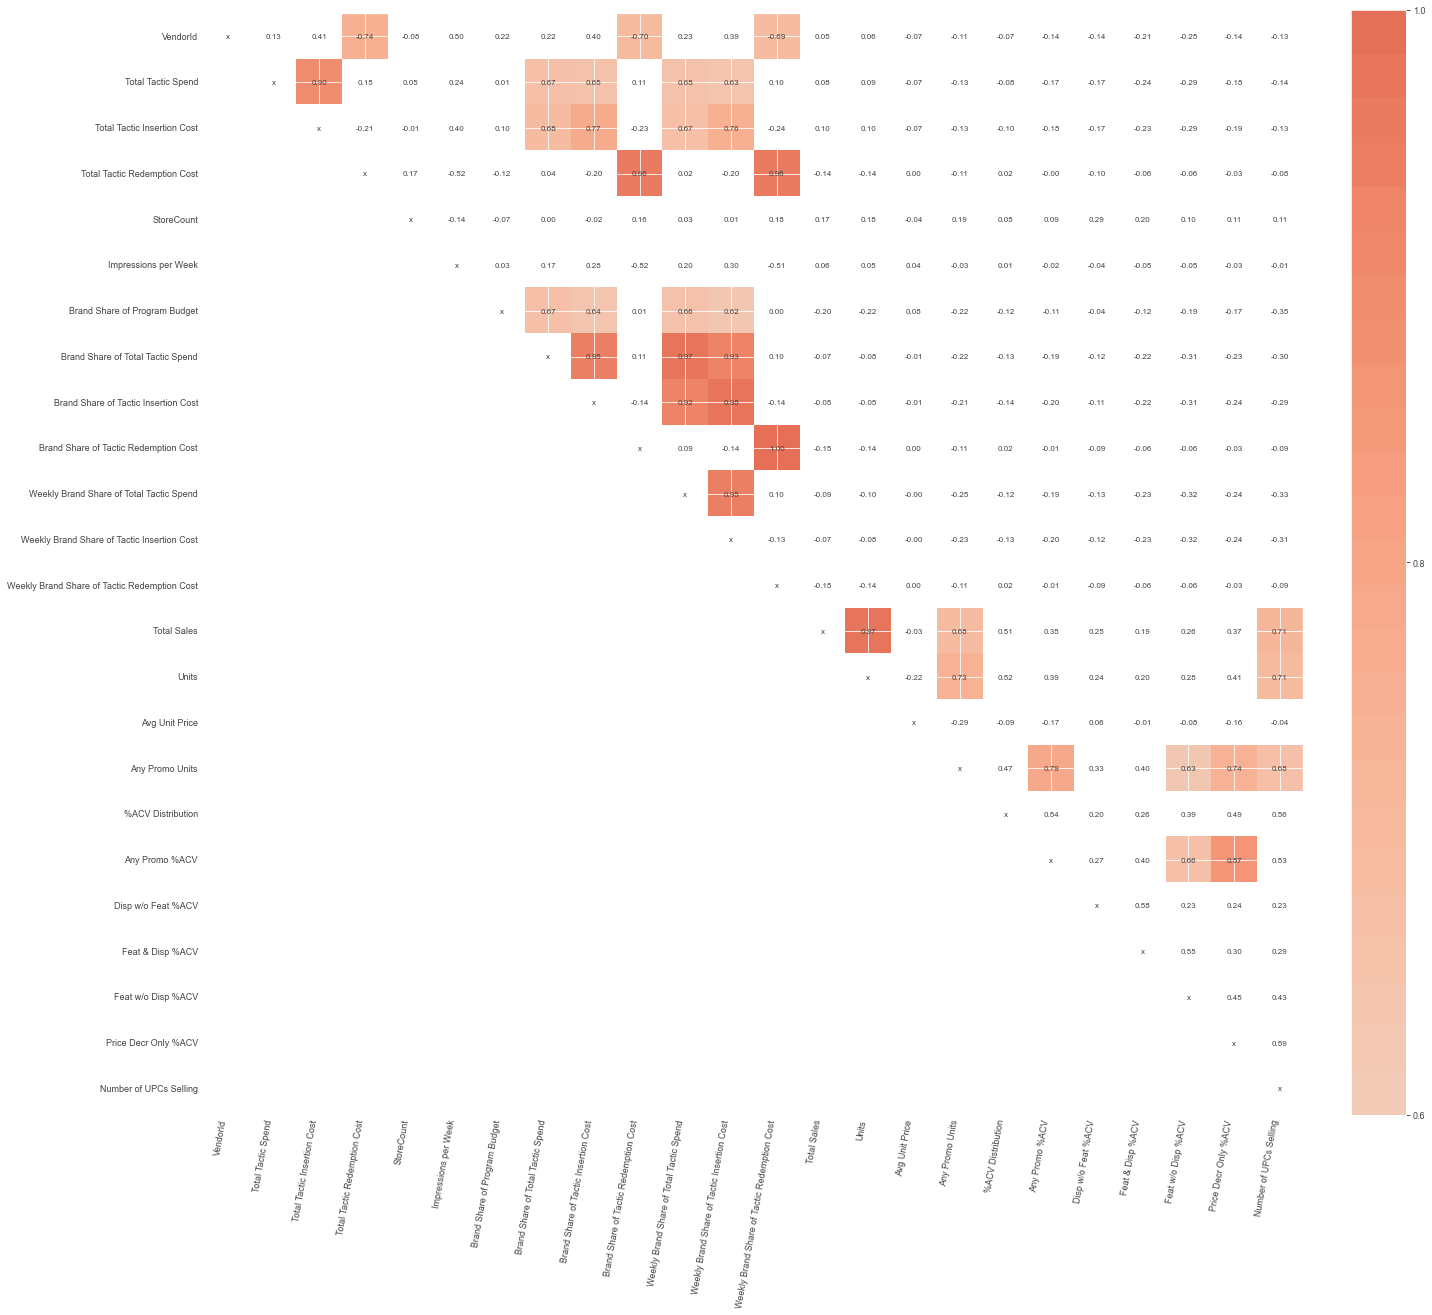

In [33]:
# this is just another visualization of correlation that I like, I may switch it with others
# is nice because it is easier to zoom in for inspection
viz = plot_corr_heatmap(df_num, figsize=(20, 20))
viz.view()

In [40]:
corr_imp = corr[abs(corr['Total Sales']) > .2]
corr_imp = corr_imp[['Total Sales']]
print(corr_imp)

                        Total Sales
VendorId                   0.204535
Total Sales                1.000000
Units                      0.913273
Any Promo Units            0.572714
Disp w/o Feat %ACV         0.284226
Number of UPCs Selling     0.379468


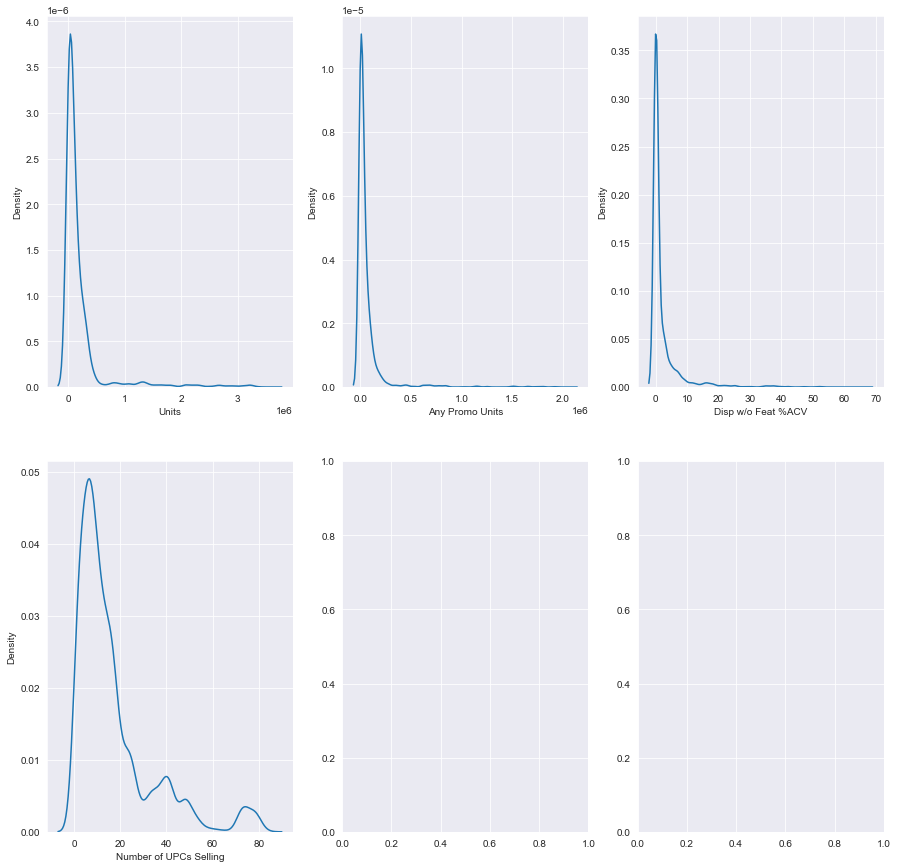

In [41]:
figure, axes = plt.subplots(2, 3, figsize=(15, 15))
sns.kdeplot(ax=axes[0, 0], x='Units', data=df_num)
sns.kdeplot(ax=axes[0, 1], x='Any Promo Units', data=df_num)
sns.kdeplot(ax=axes[0, 2], x='Disp w/o Feat %ACV', data=df_num)
sns.kdeplot(ax=axes[1, 0], x='Number of UPCs Selling', data=df_num)
plt.show()

### These kde plots will a primary tool in determining the likelihood
### distributions and giving information on the prior

In [42]:
features = ['Units', 'Any Promo Units',
            'Disp w/o Feat %ACV',
            'Number of UPCs Selling']
target = 'Total Sales'

df_all = df_num.dropna().astype(dtype='int32')
df_all = df_all[features + [target]]
df_train, df_test = train_test_split(df_all, test_size=0.15)

X_train, y_train = df_train.drop('Total Sales', axis=1), df_train['Total Sales']
X_test, y_test = df_test.drop('Total Sales', axis=1), df_test['Total Sales']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=1.0, min_samples_leaf=10, n_jobs=-1,
                       oob_score=True)

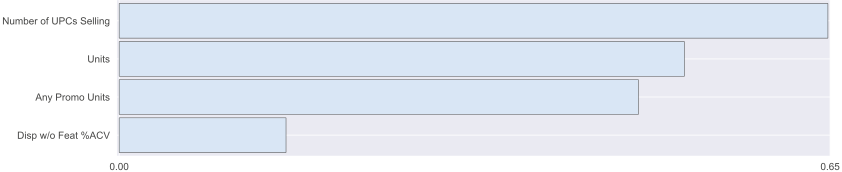

In [43]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0, warm_start=False)

I = importances(rf, X_test, y_test)
plot_importances(I, width=12, vscale=3)

### This importance plot from a RandomForestClassifier is one of the key
### ways we'll understand which variables are the most important

#### With an array of all the variables, I could make an importance plot
#### for everything but the categorical variables, but I would have to change
#### the dependent variable each time. Remember that we dropped missing values
#### instead of dropping columns, which we could do with a column that did not
#### make an impression on the correlation plot or importance plot

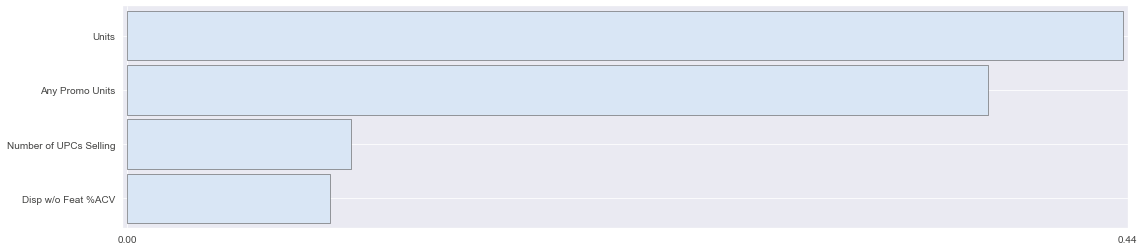

In [44]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = rf.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I, width=16, vscale=4)

#### Our categorical variables shouldn't be forgotten; just alter the threshold
#### down from 250 if the axis titles start to look messy

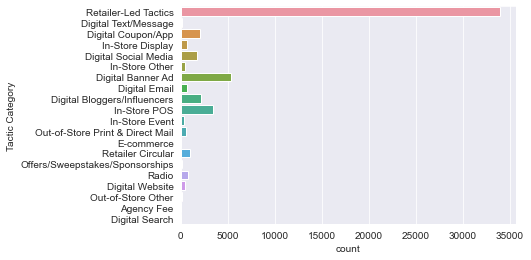

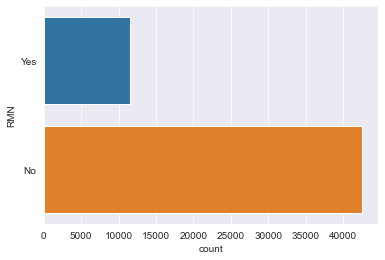

In [47]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()